<h1><center>Fake news detection  </center></h1>

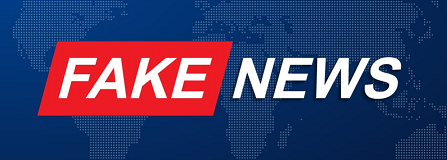

Fake news have always existed, even before social networks were around. Even in ancient Rome, emperors would use fake news to try to get as much citizens as possible on their side. 

However, the rise of social networks has led to an unprecedented spread of fake news on several topics. Whenever a relevant topic such as **covid-19** emerges, fake news often expand faster than real news as they are meant to attract a wide range of gullible users. The recent invasion of Ukraine by Russia has raised the bar for this challenge even more, as on-the-field news are much harder to verify. 

As we can imagine, the amount of content that companies like Meta and Twitter should check makes a **human-made inspection unfeasible** and, therefore, Machine and Deep Learning techniques are used for this purpose. This also creates a problem: 
- Removing **false positives** (true news that are flagged as fake news) could be seen as **censoring** a real post and heavily damages the website reputation
- Keeping **false negatives** (fake news that are flagged as true news) makes the users feel like the website **does not check the posts well enough**.

For this reason, I wanted to get a little involved in this field by trying a few well-known NLP models for text classification in the task of fake news detection. The data used for this notebook is from the following kaggle competition: \
https://www.kaggle.com/competitions/fake-news/data

#### Let's get started! 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras import layers

In [2]:
# from keras import backend as K
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# K._get_available_gpus() #Run model on GPU

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
train_data = pd.read_csv('train.csv', encoding = 'utf-8')
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
test_data = pd.read_csv('test.csv', encoding = 'utf-8')
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


The structure of the two dataset is basically identical, except the test data is missing the final label, which we will have to predict with our model and output the file into the kaggle contest. I am 6 years late for this competition, but I will still post a submission to see how well we did in the end! 

#### Check for label imbalance:

1    10413
0    10387
Name: label, dtype: int64

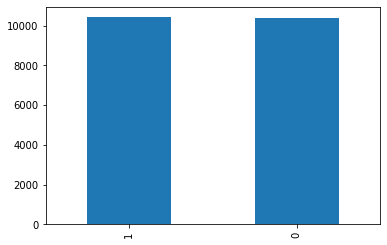

In [5]:
train_data['label'].value_counts().plot.bar()
train_data['label'].value_counts()

Check for missing values!

In [6]:
print(train_data.isna().sum(), '\n', test_data.isna().sum())

id           0
title      558
author    1957
text        39
label        0
dtype: int64 
 id          0
title     122
author    503
text        7
dtype: int64


Are there any obs with missing values on all 3 relevant columns (title, author and text)?

In [7]:
train_data[['title', 'author', 'text']].isna().all(axis=1).sum()

0

However, we can see there are 39 rows where both the text and the author are missing..

In [8]:
print(train_data[['title', 'author']].isna().all(axis=1).sum())
print(train_data[['text', 'author']].isna().all(axis=1).sum())
print(train_data[['text', 'title']].isna().all(axis=1).sum())

0
39
0


In [9]:
train_data.loc[train_data[['text', 'author']].isna().all(axis=1)].head()

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1


Luckily, **all those 39 observations have label = 1** (fake news):

In [10]:
train_data.loc[train_data[['text', 'author']].isna().all(axis=1),'label'].value_counts()

1    39
Name: label, dtype: int64

And a similar thing happens for most of our NAs, **almost 99% NAs are fake news**:

In [11]:
print(train_data.loc[train_data.isna().any(axis=1),'label'].value_counts(), '\n',
     train_data.loc[train_data.isna().any(axis=1),'label'].value_counts(normalize =True))

1    2489
0      26
Name: label, dtype: int64 
 1    0.989662
0    0.010338
Name: label, dtype: float64


Removing NAs in this case would be a bad idea, as they seem to carry more information than most words. We will use the tilda ~ token to not lose the information of NAs.

Let's perform some more EDA: words and character distribution between the two different labels 

In [12]:
train_data = train_data.fillna('~')
test_data = test_data.fillna('~')

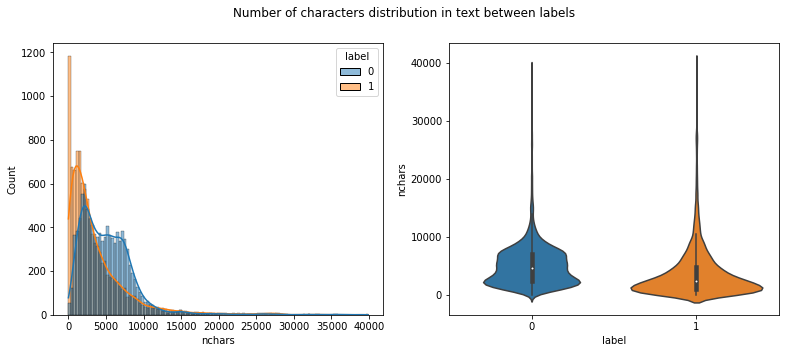

In [13]:
train_data['nchars'] = train_data['text'].apply(lambda x: len(x))
fig, axs = plt.subplots(1,2, figsize = (13,5))
sns.histplot(data = train_data.loc[train_data['nchars']<40000], x = 'nchars', hue = 'label', ax = axs[0], kde = True)
sns.violinplot(data = train_data.loc[train_data['nchars']<40000], x = 'label', y = 'nchars', ax = axs[1], kde = True)
fig.suptitle('Number of characters distribution in text between labels')
plt.show()

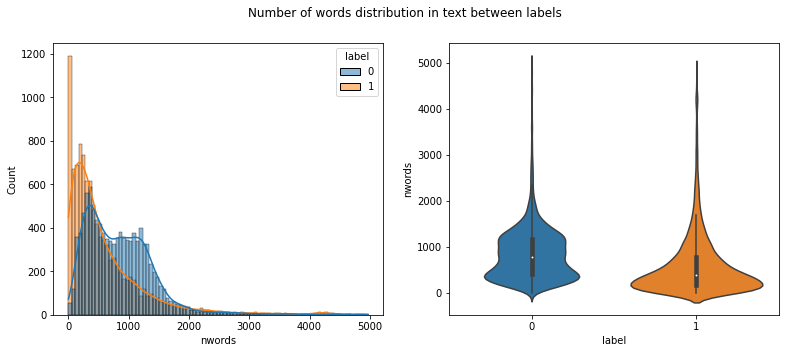

In [14]:
train_data['nwords'] = train_data['text'].apply(lambda x: len(x.split()))
fig, axs = plt.subplots(1,2, figsize = (13,5))
sns.histplot(data = train_data.loc[train_data['nwords']<5000], x = 'nwords', hue = 'label', ax = axs[0], kde = True)
sns.violinplot(data = train_data.loc[train_data['nwords']<5000], x = 'label', y = 'nwords', ax = axs[1], kde = True)
fig.suptitle('Number of words distribution in text between labels')
plt.show()

It is really interesting to see how fake news in this dataset tend to have fewer words and characters than real news. It might be useful to use one of these two features (or both) in our model! 

Does a similar thing hold for titles as well?

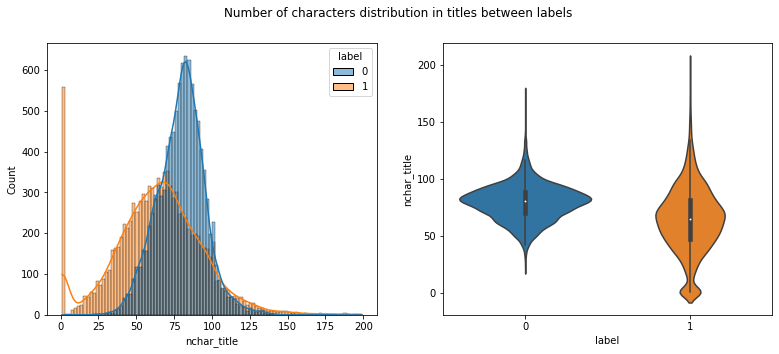

In [15]:
train_data['nchar_title'] = train_data['title'].apply(lambda x: len(x))
fig, axs = plt.subplots(1,2, figsize = (13,5))
sns.histplot(data = train_data.loc[train_data['nchar_title']<200], x = 'nchar_title', hue = 'label', ax = axs[0], kde = True)
sns.violinplot(data = train_data.loc[train_data['nchar_title']<200], x = 'label', y = 'nchar_title', ax = axs[1], kde = True)
fig.suptitle('Number of characters distribution in titles between labels')
plt.show()

In [16]:
#Create the same columns for the test data as well (in case we want to use them as features)
test_data['nchars'] = test_data['text'].apply(lambda x: len(x))
test_data['nwords'] = test_data['text'].apply(lambda x: len(x.split()))
test_data['nchar_title'] = test_data['title'].apply(lambda x: len(x))

Really interesting: except for NAs, both labels have a distribution similar to a **gaussian**, except the characters in fake news titles have a much wider distribution and a lower mean.

Let's look at the most common authors between the two categories. I imagine this to be a relevant factor as well.

<AxesSubplot:>

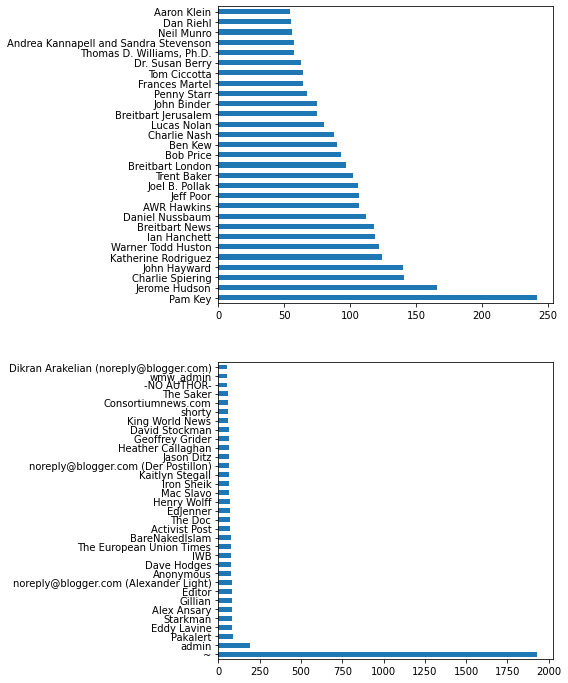

In [17]:
auth_0 = train_data.loc[train_data['label']==0, 'author']
auth_1 = train_data.loc[train_data['label']==1, 'author']

fig,axs = plt.subplots(2,1, figsize = (6, 12))
auth_0.value_counts().loc[auth_0.value_counts()>50].plot.barh(ax = axs[0])
auth_1.value_counts().loc[auth_1.value_counts()>50].plot.barh(ax = axs[1])

It is super interesting to see how fake news have a lot of NAs (~) and other unnamed authors (admin, anonymous, editor, -no author-). Who are the authors in our test set?

<AxesSubplot:>

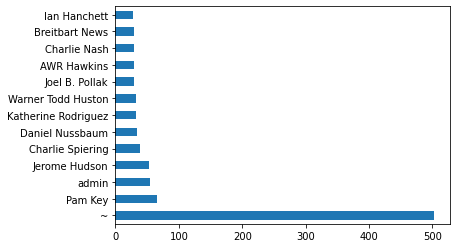

In [18]:
test_data['author'].value_counts().loc[test_data['author'].value_counts() > 25].plot.barh()

We can see how the most common authors in the training data also appear in the test data ("admin", and NAs from the label = 1, Pam Key, Jerome Hudson etc. from the label = 0).

Let's run some processing steps before getting to modeling!

### Data processing

I will perform data processing only on copies of the original data to preserve the original phrases, just in case I will ever need to look back at them.

In [19]:
#One hot encoding of author variable
auth_train = pd.get_dummies(train_data['author'])
auth_test = pd.get_dummies(test_data['author'])
aut_train, aut_test = auth_train.align(auth_test, join='outer', axis=1, fill_value=0)

In [20]:
colX = ['text','title', 'nchars', 'nchar_title']
coly = ['label']

X_train_prep = train_data[colX].copy()
y_train_prep = train_data[coly].copy()

X_test_prep = test_data[colX].copy()

In [21]:
from nltk.corpus import stopwords
from string import punctuation 

sw = set(stopwords.words('english'))
punct = list(punctuation)
sw.update(punct)

#Let's remove ~ from the punctuation list as it is our indicator for NAs!
sw.remove('~')

def clean_data(txt):
    col = [i.strip() for i in txt.split()  if i.strip().lower() not in sw if i.strip().isalpha()]
    return ' '.join(col)

#We will only remove the these characters from the main text
X_train_prep['text'] = X_train_prep['text'].apply(lambda x: clean_data(x))
X_test_prep['text'] = X_test_prep['text'].apply(lambda x:clean_data(x))

Now that we have removed stop words, we can take look at the most common words in both groups.

In [22]:
texts_fake = [obs['text'] for n,obs in train_data.loc[train_data['label']==1].iterrows()]
texts_fake = ' '.join(texts_fake)
texts_true = [obs['text'] for n,obs in train_data.loc[train_data['label']==0].iterrows()]
texts_true = ' '.join(texts_true)

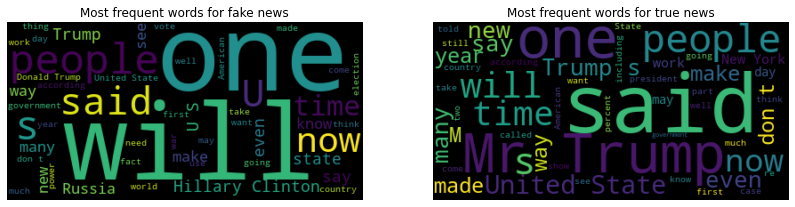

In [23]:
from wordcloud import WordCloud, ImageColorGenerator

fig, axs = plt.subplots(1,2,figsize = (14,7))
wordcloud_fake = WordCloud(max_words = 50).generate(texts_fake)
axs[0].imshow(wordcloud_fake, interpolation='bilinear')
axs[0].set_title('Most frequent words for fake news')
axs[0].axis("off")

wordcloud_true = WordCloud(max_words = 50).generate(texts_true)
axs[1].imshow(wordcloud_true, interpolation='bilinear')
axs[1].set_title('Most frequent words for true news')
axs[1].axis("off")
plt.show()

### Lemmatization and tokenization
We will perform lemmatization and tokenization as our last data preparation step before starting modeling 

In [24]:
import nltk
from nltk.stem import WordNetLemmatizer 

def lemmatize_sentence(sentence):
    
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(sentence)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in words])
    
    return lemmatized_output

X_train_prep['text'] = X_train_prep['text'].apply(lambda x: lemmatize_sentence(x))
X_test_prep['text'] = X_test_prep['text'].apply(lambda x: lemmatize_sentence(x))

And now we're ready for the last part: **modeling**! The data for the competition has to be submitted in the following format:

| id | label |
| --- | --- |
| 20806 | 1 | 
| 20807 | 0 |
| 20808 | 0 |
| 20809 | 1 |

Se we will have two columns: ID of the test set observation and the predicted label.\
We will submit two models: an LSTM and a BERT model, and evaluate them.

---- 

We will split the training data as follows: 
- 72% training set
- 18% validation set
- 10% test set

We will do so by first splitting in 90% training and 10% test, and then in the keras.fit() method we will pass validation_split=0.2, leading to the result that we just described.

In [25]:
X_train, X_test, author_train, author_test ,y_train, y_test = train_test_split(X_train_prep, aut_train, y_train_prep, 
                                                        random_state = 42, test_size=.1)

print(X_train.shape, X_test.shape)

(18720, 4) (2080, 4)


We will make use of Tensorflow's **functional API** in order to use the 3 different text features and the character counts.

In [26]:
#Check total amount of unique words (we need this for the input)
unique_texts = [obs['text'] for n,obs in X_train_prep.iterrows()]
unique_texts = ' '.join(unique_texts).split(' ')
print(len(np.unique(unique_texts)))
unique_titles = [obs['title'] for n,obs in X_train_prep.iterrows()]
unique_titles = ' '.join(unique_titles).split(' ')
print(len(np.unique(unique_titles)))

nauthors = len(author_train.columns)//2 #Many authors only have very only 1 or 2 articles

160313
41849


In [27]:
txt_train = X_train['text']
title_train = X_train['title']
chars_train = X_train[['nchars','nchar_title']]

txt_test = X_test['text']
title_test = X_test['title']
chars_test = X_test[['nchars','nchar_title']]

In [28]:
num_words_text = 10000 #Only use some words 
num_words_title = 1000
num_cols_chars = 2
encoder_txt = tf.keras.layers.TextVectorization(max_tokens=num_words_text)
encoder_txt.adapt(txt_train)

encoder_title = tf.keras.layers.TextVectorization(max_tokens=num_words_title)
encoder_title.adapt(title_train)

In [29]:
text_input = tf.keras.Input(shape= [], name="text", dtype=tf.string)  
title_input = tf.keras.Input(shape= [], name="title", dtype=tf.string) 
author_input = tf.keras.Input(shape= (None,), name="author")  
# numerical_cols = tf.keras.Input(shape=(num_cols_chars,), name="numericals")

#Encoding 
text_features = encoder_txt(text_input)
title_features = encoder_title(title_input)

# Embedding of text cols inn-size vectors
text_features = layers.Embedding(num_words_text, 200)(text_features)
title_features = layers.Embedding(num_words_title, 100)(title_features)

# Apply two bidirectional LSTM layers. Turns embedded words into a n-dimensional vector
text_features = layers.Bidirectional(tf.keras.layers.LSTM(128))(text_features)
title_features = layers.Bidirectional(tf.keras.layers.LSTM(64))(title_features)

text_features = layers.BatchNormalization()(text_features)
title_features = layers.BatchNormalization()(title_features)

text_features = layers.Dropout(.2)(text_features)
title_features = layers.Dropout(.2)(title_features)

# Perform one-hot encoding on the authors column
author_features = layers.CategoryEncoding(num_tokens = nauthors, output_mode="multi_hot")(author_input)

# Merge all 4 layers into a single large vector via concatenation
x = layers.concatenate([text_features , title_features, author_features]) #numerical_cols

#Add a couple of dense layers and dropout to prevent overfitting
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(.3)(x)

#Add a final prediction layer 
out = layers.Dense(1, activation='sigmoid', name="out")(x)

model = tf.keras.Model(
    inputs=[text_input, title_input, author_input], #numerical_cols
    outputs=[out],
)

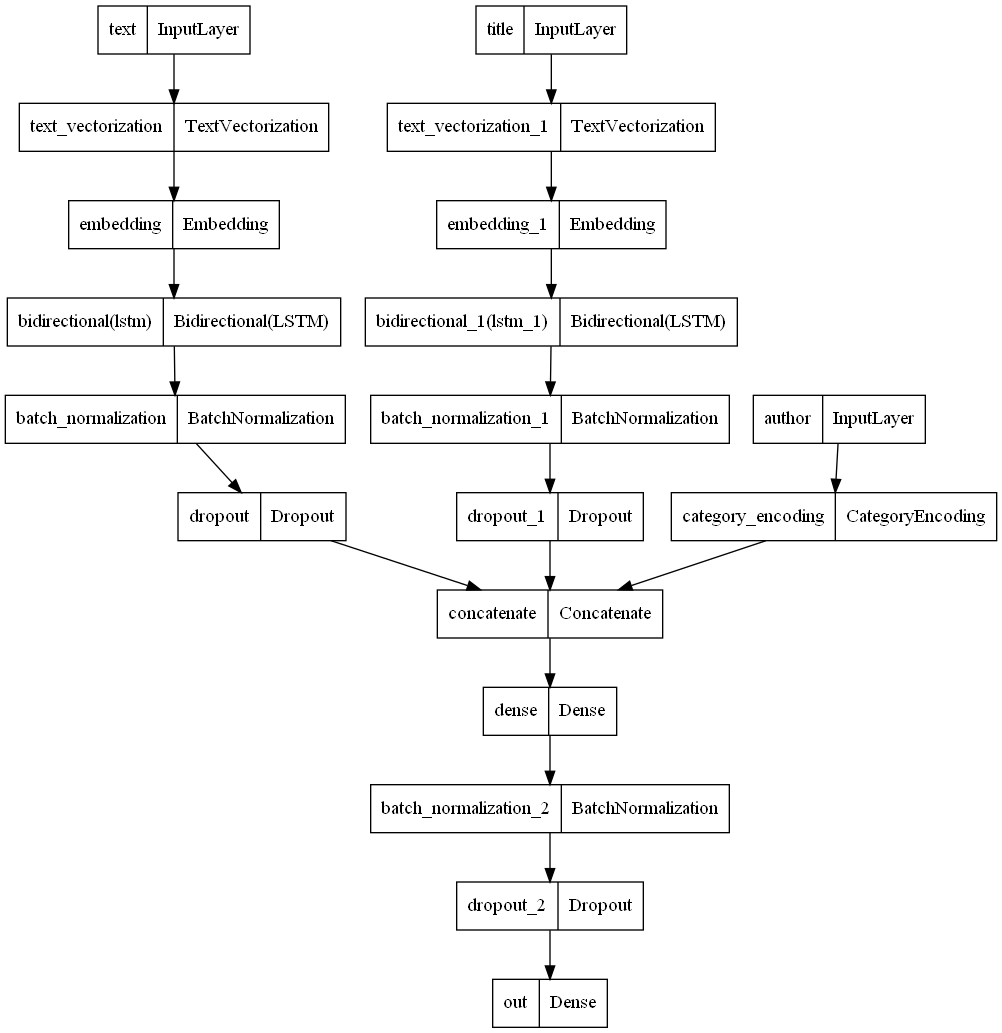

In [30]:
tf.keras.utils.plot_model(model)

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      optimizer=tf.keras.optimizers.Adam(1e-4),
      metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-5)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [31]:
history = model.fit(
    {"text": txt_train, "title": title_train, "author": author_train}, #, "numericals" : chars_train
    {"out": y_train},
    epochs=2,
    batch_size=16,
    validation_split = .1 , 
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/2
1053/1053 [==============================] - 3477s 3s/step - loss: 0.2509 - accuracy: 0.8917 - val_loss: 0.2525 - val_accuracy: 0.8846 - lr: 1.0000e-04
Epoch 2/2
1053/1053 [==============================] - 3943s 4s/step - loss: 0.0932 - accuracy: 0.9660 - val_loss: 0.0594 - val_accuracy: 0.9754 - lr: 1.0000e-04


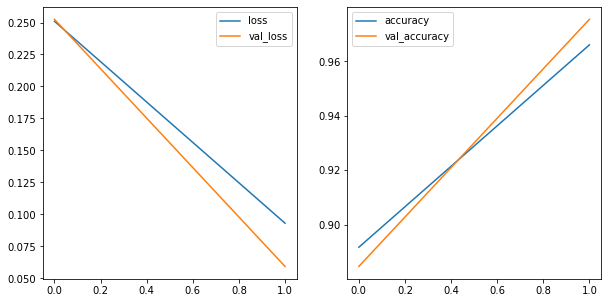

In [32]:
lstm_metrics = pd.DataFrame(history.history)

fig,axs = plt.subplots(1,2,figsize = (10,5))
lstm_metrics[['loss','val_loss']].plot(ax = axs[0])
lstm_metrics[['accuracy','val_accuracy']].plot(ax = axs[1])
plt.show()

In [33]:
yhat = pd.Series((model.predict(
    {"text": txt_test, "title": title_test, "author": author_test} #, "numericals" : chars_test
    )>.5).reshape(-1)).astype(int)

Accuracy: 0.9658653846153846 
F1-score: 0.9658817876021143


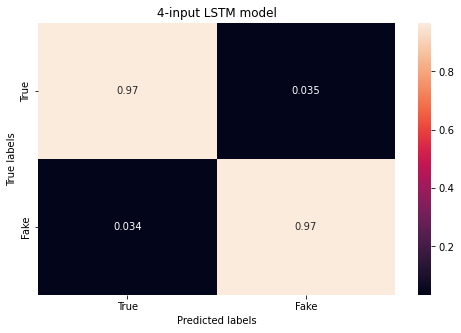

In [34]:
modelname = '3-input LSTM model'

print(f'Accuracy: {accuracy_score(yhat, y_test)} ')
print(f'F1-score: {f1_score(yhat,y_test) }')

cm = confusion_matrix(y_test, yhat, normalize = 'true')

fig , ax= plt.subplots(figsize = (8,5))
sns.heatmap(cm, annot=True, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
ax.set_title(modelname)

ax.xaxis.set_ticklabels(('True','Fake'))
ax.yaxis.set_ticklabels(('True','Fake'))
plt.show()

Export results for test set submission on kaggle! 

In [50]:
yhat_sub = pd.Series((model.predict(
    {"text": X_test_prep['text'], "title": X_test_prep['title'], "author": auth_test}
    )>.5).reshape(-1)).astype(int)

In [55]:
res_model1 = pd.DataFrame({'id' : test_data['id'],
                          'label' : yhat_sub})
res_model1.to_csv('submit_mod1.csv', sep = ',', index = False)

That's good! We got public and private scores for our submission and received scores of about 97%, which would place us about 3rd in the public leaderboard and 5th in the private leaderboard!

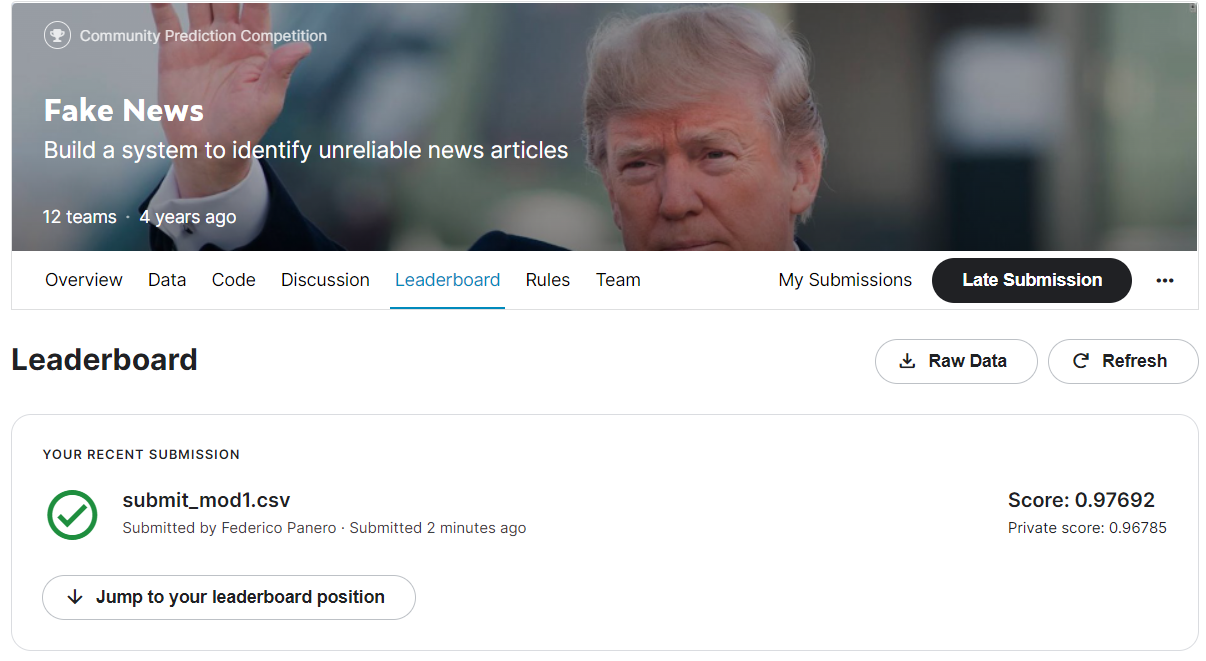

Can we get further in the leaderboards by replacing the two GRU models with a transformer? Let's try BERT! 

We will start by downloading a pretrained version of Bert, substitue the GRU layers from the previous model with it and will train the model as follows: 
- 3 epochs where the BERT layer is frozen and we only train the dense layers in the final part of the model; 
- 1 epoch where all layers are trainable (BERT included) for fine tuning.

In [28]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [29]:
nwords = 100
text_train_input_ids, text_train_attention_masks = bert_encode(txt_train,nwords)
text_test_input_ids, text_test_attention_masks = bert_encode(txt_test,nwords)

title_train_input_ids, title_train_attention_masks = bert_encode(title_train,nwords)
title_test_input_ids, title_test_attention_masks = bert_encode(title_test,nwords)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\ilpan\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [74]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    text_input_ids = tf.keras.Input(shape=(nwords,),dtype='int32', name = 'text_id')
    text_attention_masks = tf.keras.Input(shape=(nwords,),dtype='int32', name = 'text_mask')

    title_input_ids = tf.keras.Input(shape=(nwords,),dtype='int32', name = 'title_id')
    title_attention_masks = tf.keras.Input(shape=(nwords,),dtype='int32', name = 'title_mask')
    
    author_input = tf.keras.Input(shape= (None,), name="authors")  

    text_out = bert_model([text_input_ids, text_attention_masks])[1]
    title_out = bert_model([title_input_ids, title_attention_masks])[1]
    
# next thing to try: freezing the bert layers and only learn the representations on top of it    
    bert_model.trainable = False
    
    author_features = layers.CategoryEncoding(num_tokens = nauthors, output_mode="multi_hot")(author_input)
    
    x = layers.concatenate([text_out, title_out, author_features ])  
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    output = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [text_input_ids,text_attention_masks,
                                           title_input_ids, title_attention_masks, author_input],
                                  outputs = output)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model



model = create_model(bert_model)

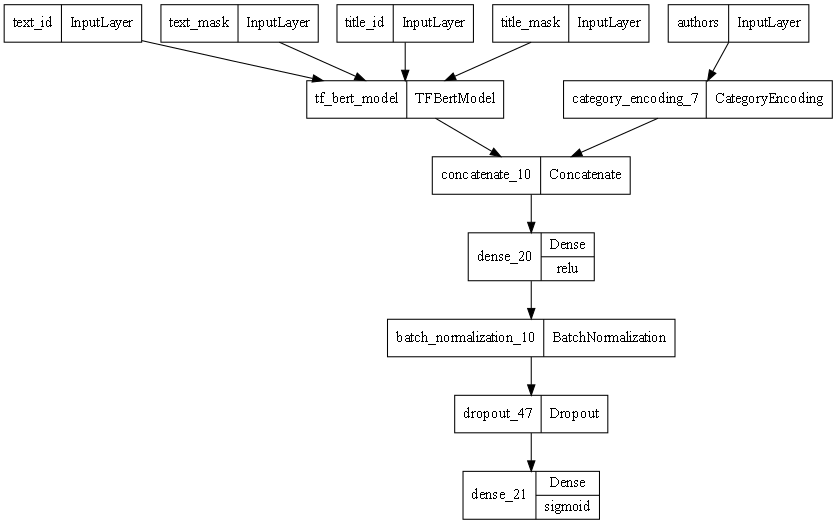

In [91]:
tf.keras.utils.plot_model(model, show_layer_activations=True, dpi = 75)

In [76]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_id (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 text_mask (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 title_id (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 title_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                           

In [77]:
history = model.fit(
    {"text_id": text_train_input_ids, "text_mask": text_train_attention_masks,
     "title_id": title_train_input_ids, "title_mask": title_train_attention_masks, "authors": author_train
    },
    y_train,
    validation_split=0.1, 
    epochs=3,
    batch_size=16
)

Epoch 1/3
1053/1053 [==============================] - 3879s 4s/step - loss: 0.0436 - accuracy: 0.9935 - val_loss: 0.0306 - val_accuracy: 0.9888
Epoch 2/3
1053/1053 [==============================] - 3820s 4s/step - loss: 0.0251 - accuracy: 0.9959 - val_loss: 0.0311 - val_accuracy: 0.9888
Epoch 3/3
1053/1053 [==============================] - 3810s 4s/step - loss: 0.0194 - accuracy: 0.9970 - val_loss: 0.0312 - val_accuracy: 0.9893


In [78]:
#unfreeze the layers and train again for a single step and with a lower learning rate
model.trainable = True 
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_id (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 text_mask (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 title_id (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 title_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                           

In [79]:
model.compile(Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
    {"text_id": text_train_input_ids, "text_mask": text_train_attention_masks,
     "title_id": title_train_input_ids, "title_mask": title_train_attention_masks, "authors": author_train
    },
    y_train,
    validation_split=0.1, 
    epochs=1,
    batch_size=16
)

1053/1053 [==============================] - 9729s 9s/step - loss: 0.0158 - accuracy: 0.9974 - val_loss: 0.0310 - val_accuracy: 0.9893


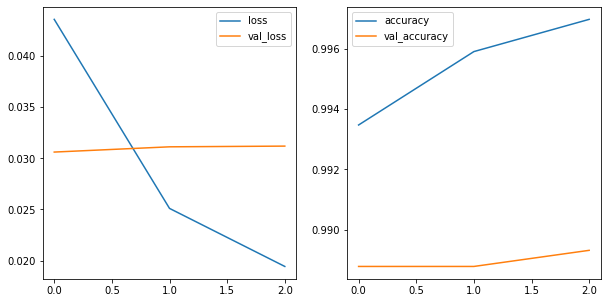

In [80]:
bert_metrics = pd.DataFrame(history.history)

fig,axs = plt.subplots(1,2,figsize = (10,5))
bert_metrics[['loss','val_loss']].plot(ax = axs[0])
bert_metrics[['accuracy','val_accuracy']].plot(ax = axs[1])
plt.show()

In [81]:
yhat = pd.Series((model.predict(
        {"text_id": text_test_input_ids, "text_mask": text_test_attention_masks,
     "title_id": title_test_input_ids, "title_mask": title_test_attention_masks, 
         "authors": author_test}
    )>.5).reshape(-1)).astype(int)

Accuracy: 0.9879807692307693 
F1-score: 0.9879980796927509


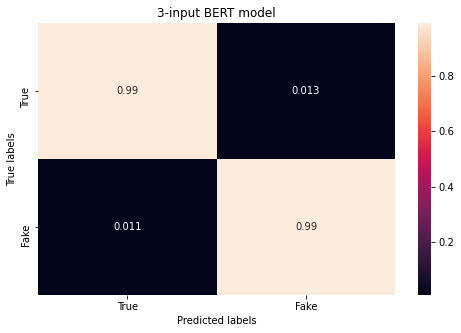

In [82]:
modelname = '3-input BERT model'

print(f'Accuracy: {accuracy_score(yhat, y_test)} ')
print(f'F1-score: {f1_score(yhat,y_test) }')

cm = confusion_matrix(y_test, yhat, normalize = 'true')

fig , ax= plt.subplots(figsize = (8,5))
sns.heatmap(cm, annot=True, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
ax.set_title(modelname)

ax.xaxis.set_ticklabels(('True','Fake'))
ax.yaxis.set_ticklabels(('True','Fake'))
plt.show()

These results seem really good! Let's make another submission on kaggle and see the final verdict!

In [83]:
text_final_input_ids, text_final_attention_masks = bert_encode(X_test_prep['text'],nwords)

title_final_input_ids, title_final_attention_masks = bert_encode(X_test_prep['title'],nwords)

C:\Users\ilpan\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [84]:
yhat_sub2 = pd.Series((model.predict(
    {"text_id": text_final_input_ids, "text_mask": text_final_attention_masks,
     "title_id": title_final_input_ids, "title_mask": title_final_attention_masks, 
         "authors": auth_test}
    )>.5).reshape(-1)).astype(int)

In [85]:
res_model2 = pd.DataFrame({'id' : test_data['id'],
                          'label' : yhat_sub2})
res_model2.to_csv('submit_mod3.csv', sep = ',', index = False)

The results are better than the GRU model: we got a **98.9%** public score and a **98.5%** private score, which would place us about **1st place** in the public leaderboard and **2nd** place in the private leaderboard (just 0.02% below first place)!
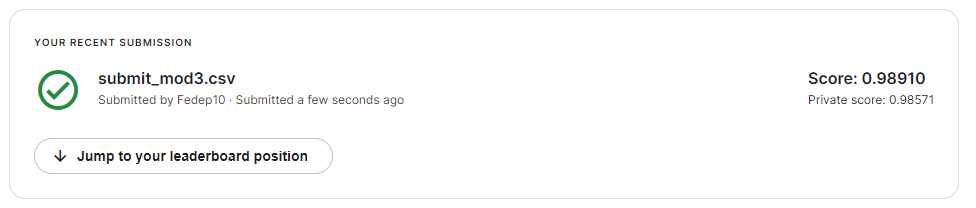